In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
import statsmodels.api as sm

from rliable import plot_utils as rliable_plot_utils
from qscaled.utils.configs import BaseConfig
from qscaled.utils.zip_handler import fetch_zip_data

from scripts.wandb_utils.zip_handler import ModelSizeZipHandler
from scripts.core.preprocess import truncate
from scripts.constants import DEFAULT_MAX_STEPS

from scripts.experiments.utd_x_width_x_bs.plot_utils import COLORS

import qscaled

qscaled.constants.QSCALED_PATH = os.path.expanduser('~/.value-scaling')
qscaled.constants.suppress_overwrite_prompt = True

In [ ]:
ModelSizeSweepConfig = BaseConfig


config_input_dict = dict(
    max_returns={},
    returns_key='return',
    thresholds=[],  # placeholder
)

config = ModelSizeSweepConfig(
    name='overfitting',  # Zip filename
    wandb_collector=None,
    zip_handler_cls=ModelSizeZipHandler,
    **config_input_dict,
)

truncate_steps = DEFAULT_MAX_STEPS

df = fetch_zip_data(config, use_cached=True)
df = truncate(df, truncate_steps)

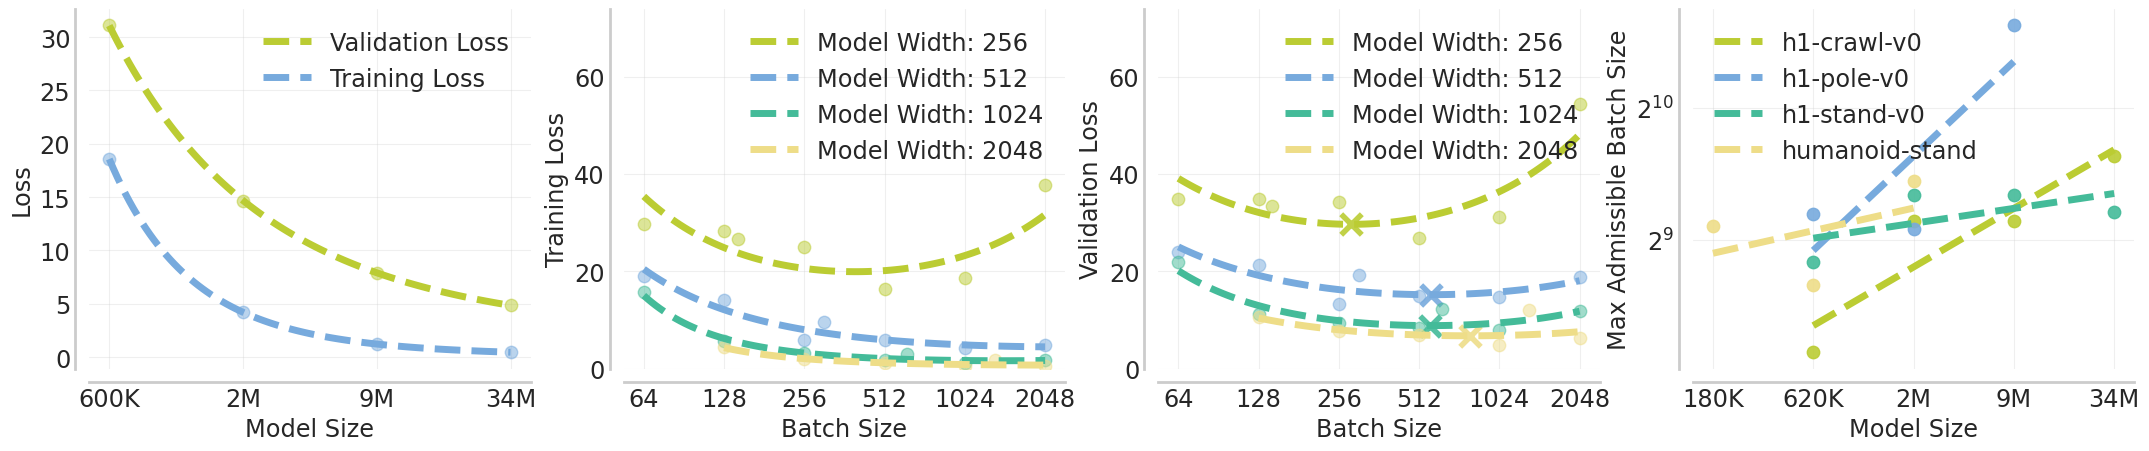

In [9]:
ENV = 'h1-crawl-v0'


def get_data(df, metric, summarize_how, filter_utd=None):
    """Process data based on metric and summarization method."""
    df = deepcopy(df)
    if filter_utd is not None:
        df = df[df['utd'] == filter_utd]

    if summarize_how == 'end of training':
        if metric == 'return':
            df['summary'] = df[metric].apply(lambda x: x[-1])
        else:
            # Use np.nanmean to handle NaN values properly
            df['summary'] = df[metric].apply(lambda x: np.nanmean(x[-1, :]))
    elif summarize_how == 'mean over training':
        df['summary'] = df[metric].apply(lambda x: np.mean(x))
    elif summarize_how == 'median over training':
        df['summary'] = df[metric].apply(lambda x: np.median(x))
    elif summarize_how == 'last 10%':
        if metric == 'return':
            df['summary'] = df[metric].apply(lambda x: np.nanmean(x[-int(len(x) * 0.1) :]))
        else:
            df['summary'] = df[metric].apply(lambda x: np.nanmean(x[-int(len(x) * 0.1) :, :]))
    else:
        raise ValueError(f'Unknown summarize_how: {summarize_how}')

    envs = sorted(df['env_name'].unique())
    utds = sorted(df['utd'].unique())
    critic_widths = sorted(df['critic_width'].unique())
    batch_sizes = sorted(df['batch_size'].unique())

    return df, envs, utds, critic_widths, batch_sizes


# Filter data for overfitting analysis
overfitting_summary_df = df.query(
    '((env_name != "humanoid-stand" and critic_width >= 256) or '
    '(env_name == "humanoid-stand" and batch_size <= 1024 and critic_width >= 128)) '
    'and (critic_width < 4096) '
    'and batch_size >= 64 '
    'and utd == 1'
)
overfitting_summary_df['last_step'] = overfitting_summary_df['training_step'].apply(
    lambda x: x.max()
)
overfitting_summary_df = overfitting_summary_df[overfitting_summary_df['last_step'] >= 250000]

training_loss_data, envs, utds, critic_widths, batch_sizes = get_data(
    overfitting_summary_df,
    'critic_loss',
    summarize_how='last 10%',
)

# Set up plotting style
palette = sns.set_palette(COLORS)
plt.rcParams['text.usetex'] = False
plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath} \sansmath'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helveta Nue']
sns.set_style('whitegrid')

from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('custom_gradient', [COLORS[0], COLORS[1]])
n_colors = 3
colors = [cmap(i / (n_colors - 1)) for i in range(n_colors)]

"""Create plots"""
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(2596.0 / 192 * 2 * 0.8, 369.6 / 192 * 2 * 1.2)

"""Subplot 0: Validation and Training Loss vs Model Size"""
idx = 0
batch_size = 1024

# Get validation loss data
validation_loss_data, envs, utds, critic_widths, batch_sizes = get_data(
    overfitting_summary_df,
    'validation_critic_loss',
    summarize_how='last 10%',
)

# Plot validation loss
validation_loss_df = validation_loss_data.query(
    f'env_name == "{ENV}" and utd == 1 and batch_size == {batch_size}'
)

model_sizes = sorted(validation_loss_df['critic_width'].unique())

x_values = []
y_values = []
for size in model_sizes:
    subset = validation_loss_df[validation_loss_df['critic_width'] == size]
    x_values.append(size)
    y_values.append(subset['summary'].values[0])

    # Scatter plot
    axes[idx].scatter(
        size, subset['summary'].values[0], marker='o', color=COLORS[0], alpha=0.5, s=80
    )

# Fit quadratic to validation loss
x_values = np.array(x_values)
y_values = np.array(y_values)
log_x = np.log(x_values)
log_y = np.log(y_values)
X = np.column_stack([np.ones(len(log_x)), log_x, log_x**2])
quad_fit = sm.OLS(log_y, X).fit()
smooth_x = np.linspace(log_x.min(), log_x.max(), 100)
X_smooth = np.column_stack([np.ones(len(smooth_x)), smooth_x, smooth_x**2])
smooth_y = quad_fit.predict(X_smooth)

# Plot validation loss fit
axes[idx].plot(
    np.exp(smooth_x),
    np.exp(smooth_y),
    color=COLORS[0],
    linestyle='--',
    alpha=1,
    label='Validation Loss',
    linewidth=5,
)

# Plot training loss
training_loss_df = training_loss_data.query(
    f'env_name == "{ENV}" and utd == 1 and batch_size == {batch_size}'
)

x_values = []
y_values = []
for size in model_sizes:
    subset = training_loss_df[training_loss_df['critic_width'] == size]
    x_values.append(size)
    y_values.append(subset['summary'].values[0])

    # Scatter plot
    axes[idx].scatter(
        size, subset['summary'].values[0], marker='o', color=COLORS[1], alpha=0.5, s=80
    )

# Fit quadratic to training loss
x_values = np.array(x_values)
y_values = np.array(y_values)
log_x = np.log(x_values)
log_y = np.log(y_values)
X = np.column_stack([np.ones(len(log_x)), log_x, log_x**2])
quad_fit = sm.OLS(log_y, X).fit()
smooth_x = np.linspace(log_x.min(), log_x.max(), 100)
X_smooth = np.column_stack([np.ones(len(smooth_x)), smooth_x, smooth_x**2])
smooth_y = quad_fit.predict(X_smooth)

# Plot training loss fit
axes[idx].plot(
    np.exp(smooth_x),
    np.exp(smooth_y),
    color=COLORS[1],
    linestyle='--',
    alpha=1,
    label='Training Loss',
    linewidth=5,
)

axes[idx].legend(prop={'size': 'xx-large'}, ncol=1, frameon=False, loc='upper right')
axes[idx].set_xscale('log')

# Set x-axis ticks
x = [256, 512, 1024, 2048]
model_params = ['600K', '2M', '9M', '34M']
axes[idx].xaxis.set_major_locator(plt.FixedLocator(x))
axes[idx].xaxis.set_minor_locator(plt.NullLocator())
axes[idx].set_xticks(x, model_params)

rliable_plot_utils._annotate_and_decorate_axis(
    axes[idx],
    xlabel='Model Size',
    ylabel='Loss',
    labelsize='xx-large',
    ticklabelsize='xx-large',
    grid_alpha=0.3,
    legend=False,
)

"""Subplot 1: Training Loss vs Batch Size"""
idx = 1
training_loss_df = training_loss_data.query(f'env_name == "{ENV}" and utd == 1')
model_sizes = sorted(training_loss_df['critic_width'].unique())

for i, size in enumerate(model_sizes):
    subset = training_loss_df[training_loss_df['critic_width'] == size]
    batch_sizes = sorted(subset['batch_size'].unique())

    x_values = []
    y_values = []

    for batch_size in batch_sizes:
        value = subset[subset['batch_size'] == batch_size]['summary'].values[0]
        x_values.append(batch_size)
        y_values.append(value)

        # Scatter plot
        axes[idx].scatter(batch_size, value, marker='o', color=COLORS[i], alpha=0.5, s=80)

    # Fit quadratic
    x_values = np.array(x_values)
    y_values = np.array(y_values)
    log_x = np.log(x_values)
    log_y = np.log(y_values)
    X = np.column_stack([np.ones(len(log_x)), log_x, log_x**2])
    quad_fit = sm.OLS(log_y, X).fit()
    smooth_x = np.linspace(log_x.min(), log_x.max(), 100)
    X_smooth = np.column_stack([np.ones(len(smooth_x)), smooth_x, smooth_x**2])
    smooth_y = quad_fit.predict(X_smooth)

    # Plot fit
    axes[idx].plot(
        np.exp(smooth_x),
        np.exp(smooth_y),
        color=COLORS[i],
        linestyle='--',
        alpha=1,
        label=f'Model Width: {size}',
        linewidth=5,
    )

axes[idx].legend(prop={'size': 'xx-large'}, ncol=1, frameon=False, loc='upper right')
axes[idx].set_xscale('log')

# Set x-axis ticks
x = [64, 128, 256, 512, 1024, 2048]
x_ticks_labels = [f'{int(x)}' for x in x]
axes[idx].xaxis.set_major_locator(plt.FixedLocator(x))
axes[idx].xaxis.set_minor_locator(plt.NullLocator())
axes[idx].set_xticks(x, x_ticks_labels)

rliable_plot_utils._annotate_and_decorate_axis(
    axes[idx],
    xlabel='Batch Size',
    ylabel='Training Loss',
    labelsize='xx-large',
    ticklabelsize='xx-large',
    grid_alpha=0.3,
    legend=False,
)

"""Subplot 2: Validation Loss vs Batch Size"""
idx = 2
validation_loss_df = validation_loss_data.query(f'env_name == "{ENV}" and utd == 1')
model_sizes = sorted(validation_loss_df['critic_width'].unique())

for i, size in enumerate(model_sizes):
    subset = validation_loss_df[validation_loss_df['critic_width'] == size]
    batch_sizes = sorted(subset['batch_size'].unique())

    x_values = []
    y_values = []

    for batch_size in batch_sizes:
        value = subset[subset['batch_size'] == batch_size]['summary'].values[0]
        x_values.append(batch_size)
        y_values.append(value)

        # Scatter plot
        axes[idx].scatter(batch_size, value, marker='o', color=COLORS[i], alpha=0.5, s=80)

    # Fit quadratic
    x_values = np.array(x_values)
    y_values = np.array(y_values)
    log_x = np.log(x_values)
    log_y = np.log(y_values)
    X = np.column_stack([np.ones(len(log_x)), log_x, log_x**2])
    quad_fit = sm.OLS(log_y, X).fit()
    smooth_x = np.linspace(log_x.min(), log_x.max(), 100)
    X_smooth = np.column_stack([np.ones(len(smooth_x)), smooth_x, smooth_x**2])
    smooth_y = quad_fit.predict(X_smooth)

    # Plot fit
    axes[idx].plot(
        np.exp(smooth_x),
        np.exp(smooth_y),
        color=COLORS[i],
        linestyle='--',
        alpha=1,
        label=f'Model Width: {size}',
        linewidth=5,
    )

    # Find inflection point
    quad_coef = quad_fit.params[2]
    if quad_coef > 0:
        # Find minimum of quadratic fit
        a, b = quad_fit.params[2], quad_fit.params[1]
        min_x_log = -b / (2 * a) if a != 0 else None

        # Check if minimum is within data range
        if (
            min_x_log is not None
            and min_x_log >= np.log(subset['batch_size'].min())
            and min_x_log <= np.log(subset['batch_size'].max())
        ):
            min_x = np.exp(min_x_log)
            min_y = np.exp(quad_fit.predict([1, min_x_log, min_x_log**2])[0])

            # Mark inflection point
            axes[idx].scatter(
                min_x, min_y, marker='x', color=COLORS[i], alpha=0.9, s=220, linewidths=4
            )

axes[idx].legend(prop={'size': 'xx-large'}, ncol=1, frameon=False, loc='upper right')
axes[idx].set_xscale('log')

# Set x-axis ticks
x = [64, 128, 256, 512, 1024, 2048]
x_ticks_labels = [f'{int(x)}' for x in x]
axes[idx].xaxis.set_major_locator(plt.FixedLocator(x))
axes[idx].xaxis.set_minor_locator(plt.NullLocator())
axes[idx].set_xticks(x, x_ticks_labels)

rliable_plot_utils._annotate_and_decorate_axis(
    axes[idx],
    xlabel='Batch Size',
    ylabel='Validation Loss',
    labelsize='xx-large',
    ticklabelsize='xx-large',
    grid_alpha=0.3,
    legend=False,
)

"""Subplot 3: Model Size vs Max Admissible Batch Size"""
idx = 3
envs = sorted(validation_loss_data['env_name'].unique())

for i, env in enumerate(envs):
    subset = validation_loss_data[validation_loss_data['env_name'] == env]
    # Drop NaN values in summary column
    subset = subset.dropna(subset=['summary'])
    model_sizes = sorted(subset['critic_width'].unique())

    inflection_x_values = []
    inflection_y_values = []

    for size in model_sizes:
        subsubset = subset[subset['critic_width'] == size]
        batch_sizes = sorted(subsubset['batch_size'].unique())

        # Find inflection point
        x_values = []
        y_values = []

        for batch_size in batch_sizes:
            value = subsubset[subsubset['batch_size'] == batch_size]['summary'].values[0]
            x_values.append(batch_size)
            y_values.append(value)

        # Fit quadratic to find inflection point
        x_values = np.array(x_values)
        y_values = np.array(y_values)
        log_x = np.log(x_values)
        log_y = np.log(y_values)
        X = np.column_stack([np.ones(len(log_x)), log_x, log_x**2])
        quad_fit = sm.OLS(log_y, X).fit()

        # Get inflection point
        quad_coef = quad_fit.params[2]
        if quad_coef > 0:
            # Find minimum of quadratic fit
            a, b = quad_fit.params[2], quad_fit.params[1]
            min_x_log = -b / (2 * a) if a != 0 else None

            # Check if minimum is within data range
            if (
                min_x_log is not None
                and min_x_log >= np.log(subset['batch_size'].min())
                and min_x_log <= np.log(subset['batch_size'].max())
            ):
                min_x = np.exp(min_x_log)
                inflection_x_values.append(size)
                inflection_y_values.append(min_x)

                # Scatter plot
                axes[idx].scatter(size, min_x, marker='o', color=COLORS[i], alpha=0.9, s=80)

    # Fit line for inflection points
    if len(inflection_x_values) > 1:
        inflection_x_values = np.array(inflection_x_values)
        inflection_y_values = np.array(inflection_y_values)
        smooth_x = np.log(inflection_x_values)
        smooth_y = np.log(inflection_y_values)
        linear_fit = sm.OLS(smooth_y, sm.add_constant(smooth_x)).fit()
        y_fit = linear_fit.predict(sm.add_constant(smooth_x))

        # Plot fit
        axes[idx].plot(
            np.exp(smooth_x),
            np.exp(y_fit),
            color=COLORS[i],
            linestyle='--',
            alpha=1,
            label=f'{env}',
            linewidth=5,
        )

axes[idx].legend(prop={'size': 'xx-large'}, ncol=1, frameon=False)
axes[idx].set_xscale('log')
axes[idx].set_yscale('log', base=2)

# Set x-axis ticks
x = [128, 256, 512, 1024, 2048]
model_params = ['180K', '620K', '2M', '9M', '34M']
axes[idx].xaxis.set_major_locator(plt.FixedLocator(x))
axes[idx].xaxis.set_minor_locator(plt.NullLocator())
axes[idx].set_xticks(x, model_params)

rliable_plot_utils._annotate_and_decorate_axis(
    axes[idx],
    xlabel='Model Size',
    ylabel='Max Admissible Batch Size',
    labelsize='xx-large',
    ticklabelsize='xx-large',
    grid_alpha=0.3,
    legend=False,
)

# Adjust y-axis limits
prev_ylim = axes[2].get_ylim()
axes[1].set_ylim(0, 1.3 * prev_ylim[1])
axes[2].set_ylim(0, 1.3 * prev_ylim[1])
plt.tight_layout(w_pad=-0.5)